In [2]:
import numpy as np
!pip install pandas
import pandas as pd 
import os

In [3]:
dataset_path="C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset"
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(1).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(10).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(100).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(11).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(12).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(13).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(14).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(15).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(16).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\image(17).jpg
C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Dataset\Testing\glioma_tumor\im

In [4]:
import os

# Adjust this based on what folder structure you see
base_path = os.path.join(dataset_path, 'Training')
categories = ["glioma", "meningioma", "notumor", "pituitary"]

In [5]:
import tensorflow as tf

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [7]:
categories = os.listdir(base_path)

image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    
    if not os.path.isdir(category_path):
        continue  # Skip if it's not a folder

    for image_name in os.listdir(category_path):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(category_path, image_name)
            image_paths.append(image_path)
            labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

print(df.tail())


                                              image_path            label
31425  C:/Users/avina/MyProjects/Brain_tumour_using_G...  pituitary_tumor
31426  C:/Users/avina/MyProjects/Brain_tumour_using_G...  pituitary_tumor
31427  C:/Users/avina/MyProjects/Brain_tumour_using_G...  pituitary_tumor
31428  C:/Users/avina/MyProjects/Brain_tumour_using_G...  pituitary_tumor
31429  C:/Users/avina/MyProjects/Brain_tumour_using_G...  pituitary_tumor


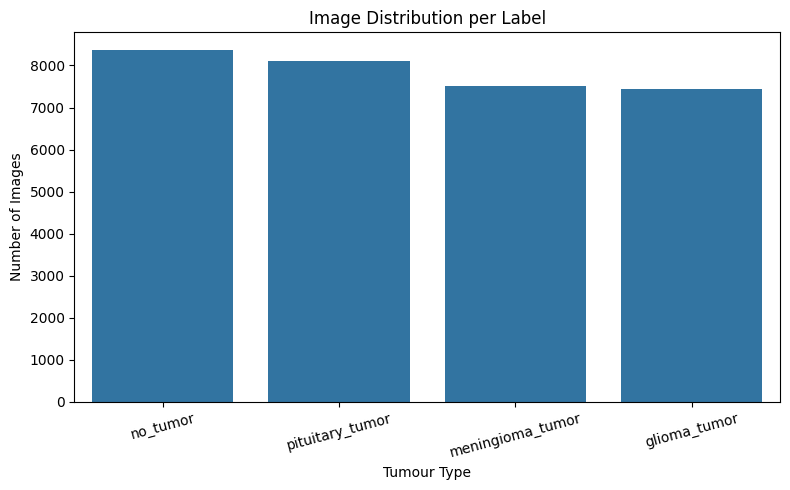

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Image Distribution per Label')
plt.xlabel('Tumour Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

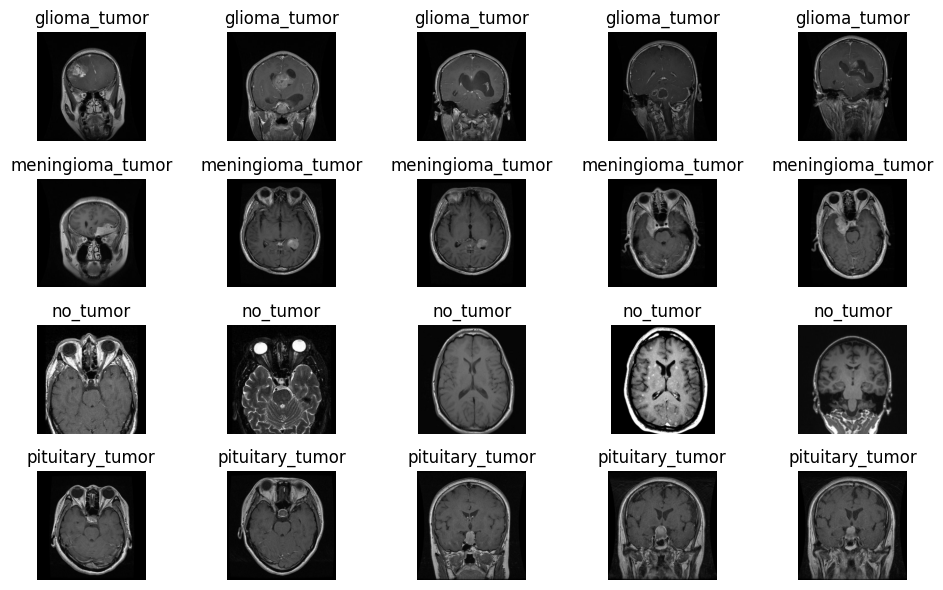

In [9]:
import cv2

num_images = 5

plt.figure(figsize = (10,6))

for i,category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]
    for j , image_path in enumerate(category_images):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories),num_images,i*num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['category'] = le.fit_transform(df['label'])

In [15]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled,y_resampled = ros.fit_resample(df[['image_path']],df['category'])
df_resampled = pd.DataFrame(X_resampled,columns = ['image_path'])
df_resampled['category'] = y_resampled
print(df_resampled['category'].value_counts())
df_resampled

category
0    8370
1    8370
2    8370
3    8370
Name: count, dtype: int64


,image_path,category
0,C:/Users/avina/MyProjects/Brain_tumour_using_G...,0
1,C:/Users/avina/MyProjects/Brain_tumour_using_G...,0
2,C:/Users/avina/MyProjects/Brain_tumour_using_G...,0
3,C:/Users/avina/MyProjects/Brain_tumour_using_G...,0
4,C:/Users/avina/MyProjects/Brain_tumour_using_G...,0
...,...,...
33475,C:/Users/avina/MyProjects/Brain_tumour_using_G...,3
33476,C:/Users/avina/MyProjects/Brain_tumour_using_G...,3
33477,C:/Users/avina/MyProjects/Brain_tumour_using_G...,3
33478,C:/Users/avina/MyProjects/Brain_tumour_using_G...,3


In [16]:
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')


check


In [17]:
df_resampled['category'] = df_resampled['category'].astype(str)

In [18]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category']
)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 26784 validated image filenames belonging to 4 classes.
Found 3348 validated image filenames belonging to 4 classes.
Found 3348 validated image filenames belonging to 4 classes.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [22]:
early_stopping = EarlyStopping(monitor='accuracy', patience=7, restore_best_weights=True)

In [23]:
# Import necessary modules from TensorFlow and Keras
from tensorflow.keras.applications.resnet50 import ResNet50  # Correct model import
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,
    GaussianNoise, Input, MultiHeadAttention, Reshape
)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Function to create a ResNet50-based CNN model with attention
def create_resnet_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Load pretrained ResNet50 base model (no top)
    base_model = ResNet50(weights='imagenet', input_tensor=inputs, include_top=False)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Output of ResNet50
    x = base_model.output

    # Attention mechanism expects specific shape
    # ResNet50 ends in 7x7x2048
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]

    # Reshape to (batch_size, 49, 2048)
    x = Reshape((height * width, channels))(x)

    # Apply multi-head attention
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)

    # Reshape back to (7, 7, 2048)
    x = Reshape((height, width, channels))(attention_output)

    # Regularization
    x = GaussianNoise(0.25)(x)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)

    # Output layer for 4-class classification
    outputs = Dense(4, activation='softmax')(x)

    # Build model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Set input shape for RGB images
input_shape = (224, 224, 3)

# Create and compile the model
cnn_model = create_resnet_model(input_shape)

cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
# Train the model
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model to an HDF5 file
cnn_model.save("resnet_attention_model.h5")


Epoch 1/20
  34/1674 [..............................] - ETA: 4:55 - loss: 0.2148 - accuracy: 0.9136

KeyboardInterrupt: 

In [26]:
import numpy as np
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

210/210 [==============================] - 28s 132ms/step


In [27]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.18      0.30       837
           1       0.76      0.55      0.64       837
           2       0.83      0.97      0.89       837
           3       0.52      1.00      0.68       837

    accuracy                           0.67      3348
   macro avg       0.78      0.67      0.63      3348
weighted avg       0.78      0.67      0.63      3348



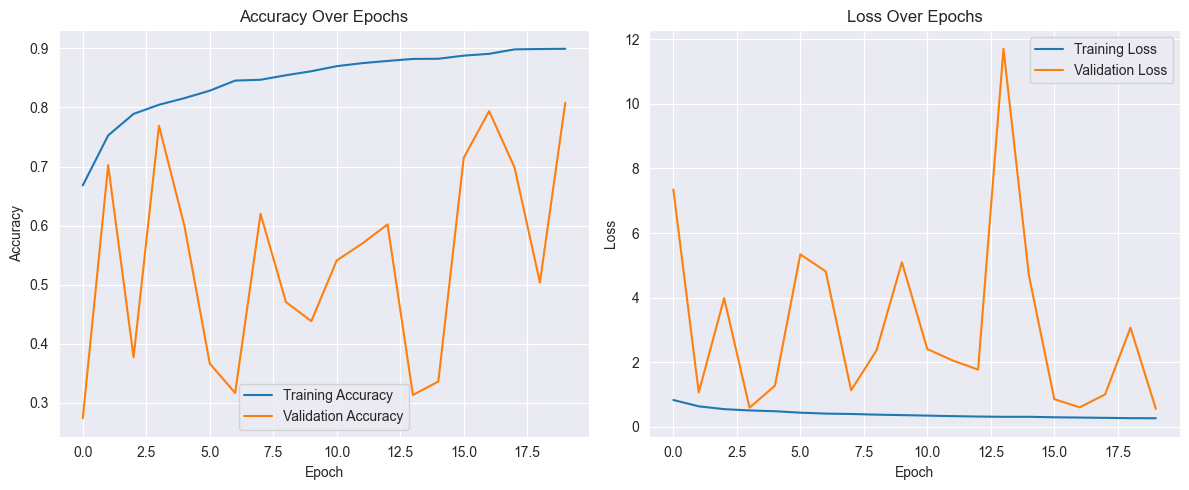

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


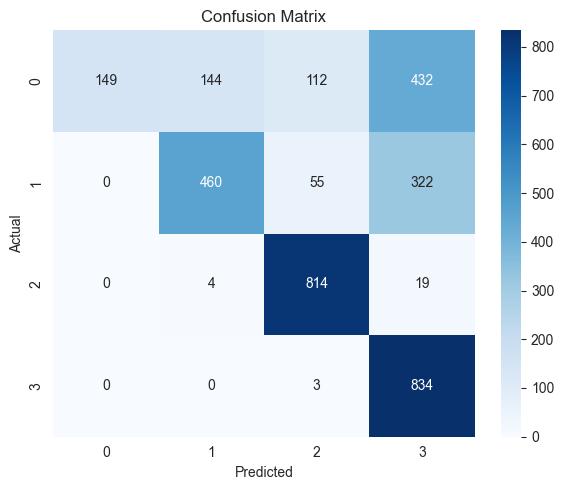

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Get the class labels from the generator
class_names = list(test_gen_new.class_indices.keys())

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Path to the best saved model
model_path = 'C:/Users/avina/MyProjects/Brain_tumour_using_GPU/Saved models/resnet_attention_model.h5'

# Load the saved model
model = load_model(model_path)

# Function to load and preprocess an image, and make a prediction
def predict_tumor(image_path):
    # Load image and resize to match the model input shape
    img = image.load_img(image_path, target_size=(224, 224))
    
    # Convert image to array and expand dimensions (add batch axis)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Optionally normalize pixel values (if your training data was normalized)
    img_array = img_array / 255.0

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Define your class labels (adjust according to your dataset)
    class_labels = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']

    # Output the result
    print(f"Predicted class: {class_labels[predicted_class]} (Confidence: {np.max(predictions)*100:.2f}%)")

# Example usage
predict_tumor('Dataset/Testing/pituitary_tumor/image(5).jpg')  # Replace with your image file path


1/1 [==============================] - 6s 6s/step
Predicted class: Pituitary (Confidence: 99.78%)
